In [ ]:
# https://arxiv.org/abs/2008.06319
#https://github.com/hubbs5/or-gym/blob/master/examples/how-to-use-rl-to-improve-your-supply-chain.ipynb

In [2]:
!pip install ray
!pip install ray[rllib]
!pip install ray[tune]
!pip install tensorflow==2.3.0


ERROR: Could not find a version that satisfies the requirement ray==1.1.0 (from versions: 1.13.0, 2.0.0rc0, 2.0.0rc1, 2.0.0, 2.0.1, 2.1.0, 2.2.0, 2.3.0rc0, 2.3.0, 2.3.1, 2.4.0, 2.5.0, 2.5.1, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0, 2.7.1, 2.7.2, 2.8.0, 2.8.1, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0, 2.11.0, 2.12.0, 2.20.0, 2.21.0, 2.22.0, 2.23.0, 2.24.0, 2.30.0, 2.31.0, 2.32.0rc0, 2.32.0, 2.33.0, 2.34.0, 2.35.0, 2.36.0, 2.36.1, 2.37.0, 2.38.0, 2.39.0, 2.40.0)
ERROR: No matching distribution found for ray==1.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 9.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0r

In [3]:
!git clone https://github.com/hubbs5/or-gym.git
%cd or-gym
!pip install -e .

Cloning into 'or-gym'...
remote: Enumerating objects: 2986, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 2986 (delta 244), reused 219 (delta 219), pack-reused 2696 (from 1)
Receiving objects: 100% (2986/2986), 24.95 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (1802/1802), done.
/content/or-gym
Obtaining file:///content/or-gym
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ...

# OR GYM Shell


In [4]:
import or_gym
from or_gym.utils import create_env
import ray
from ray.rllib.algorithms.ppo import PPO  # ray 2.0
from ray import tune
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import gymnasium as gym  # changed from gym to gymnasium
from gymnasium import spaces


# https://discuss.ray.io/t/ray-rllib-agents-ppo-missing/9904


class GymEnvWrapper(gym.Env):
    def __init__(self, env):  # Change: Take existing env as input
        self.env = env
        # Convert Gym spaces to Gymnasium spaces
        self.action_space = self._convert_space(self.env.action_space)
        self.observation_space = self._convert_space(self.env.observation_space)
        self.metadata = self.env.metadata

    def _convert_space(self, space):
        # Added import here:
        from gym.spaces import Box, Discrete, MultiDiscrete, Tuple, Dict

        if isinstance(space, Discrete):
            return spaces.Discrete(space.n)
        elif isinstance(space, Box):  # Corrected the condition
            # If the original space has dtype=int, convert it to float32
            # Force dtype to float32 for Box spaces
            dtype = np.float32
            return spaces.Box(
                low=space.low.astype(dtype),  # Ensure low is also float32
                high=space.high.astype(dtype),  # Ensure high is also float32
                shape=space.shape,
                dtype=dtype,  # Use the potentially converted dtype
            )
        elif isinstance(space, MultiDiscrete):
            return spaces.MultiDiscrete(space.nvec)
        elif isinstance(space, Tuple):
            return spaces.Tuple(tuple(self._convert_space(s) for s in space.spaces))
        elif isinstance(space, Dict):
            return spaces.Dict(
                {k: self._convert_space(v) for k, v in space.spaces.items()}
            )
        else:
            # Print detailed information for debugging:
            print(f"Unhandled space type: {type(space)}")
            print(f"Space details: {space}")
            raise NotImplementedError(
                f"Conversion for space type {type(space)} not implemented."
            )


    def step(self, action):
        # Gymnasium expects truncated to be part of the info dict
        obs, reward, done, info = self.env.step(action)

        # Add truncated to info if it's not already there,
        # assuming 'TimeLimit.truncated' is in the info dict for old API
        # You might need to adjust this based on your environment's info dict
        # If the old API is used, 'done' likely represents termination due to
        # reaching a terminal state or due to truncation. We try to separate
        # them based on the presence of 'TimeLimit.truncated' in the info.
        truncated = info.get("TimeLimit.truncated", False)

        # If truncated is True, it means the episode ended due to truncation,
        # not necessarily reaching a terminal state. We adjust 'done' accordingly.
        # If truncated is False and done is True, the episode ended due to
        # reaching a terminal state.
        # If truncated is False and done is False, the episode is still ongoing.
        if truncated:
            terminated = False  # Set terminated to False if truncated is True
        else:
            terminated = done  # If not truncated, terminated is the same as done

        info["truncated"] = truncated

        # Ensure obs is float32 and within observation space
        obs = obs.astype(np.float32)
        obs = np.clip(obs, self.observation_space.low, self.observation_space.high)

        # Return 5 values: obs, reward, terminated, truncated, info
        return obs, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        # Gymnasium expects observations and info dict
        # If the wrapped environment doesn't support the 'seed' argument,
        # call reset without it. Also, handle cases where reset returns
        # only one value or None.
        try:
            reset_result = self.env.reset(seed=seed)
        except TypeError:
            reset_result = self.env.reset()

        # Check if reset_result is None
        if reset_result is None:
            # If None, provide a default observation and empty info
            obs = self.observation_space.sample()  # Sample from observation space
            info = {}
        else:
            # Check the length of the reset result and adjust accordingly
            if isinstance(reset_result, tuple) and len(reset_result) == 2:
                obs, info = reset_result
            else:  # Assume only observation is returned
                obs = reset_result
                info = {}  # Create an empty info dictionary

        # Ensure obs is float32 and within observation space
        obs = obs.astype(np.float32)
        obs = np.clip(obs, self.observation_space.low, self.observation_space.high)

        return obs, info

    def render(self, mode="human"):
        return self.env.render(mode)

    def close(self):
        return self.env.close()


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [ ]:
#used for prelim environment

def register_env(env_name, env_config={}):
    # Create the environment using create_env
    env = create_env(env_name)(env_name, env_config=env_config)
    # Wrap the environment with GymEnvWrapper
    wrapped_env = GymEnvWrapper(env)
    # Register the wrapped environment
    tune.register_env(env_name, lambda _: wrapped_env)


# Environment and RL Configuration Settings
env_name = 'InvManagement-v0'
# env_name = "Knapsack-v0"
env_config = {}  # Change environment parameters here

# Register the environment with Ray/Tune
register_env(env_name, env_config)

In [5]:
#used for results in final report

def register_env(env_name, env_config={}):
    # Create the environment using create_env
    env = create_env(env_name)(env_name, env_config=env_config)
    # Wrap the environment with GymEnvWrapper
    wrapped_env = GymEnvWrapper(env)
    # Register the wrapped environment
    tune.register_env(env_name, lambda _: wrapped_env)


# Environment and RL Configuration Settings
env_name = "InvManagement-v0"
# env_name = "Knapsack-v0"
env_config = {'periods':240,
              'I0' : [100,100,150,200,200], #five arguements determiens 6 stages
              'p' : 10, # Final Product Price
              'r' : [1.5, 1.25, 1, 0.75, 0.5,0.25],
              'k': [0.15, 0.125, 0.1, 0.075, 0.05, 0.025],
              'h' : [0.25, 0.2, 0.15, 0.1, 0.05],

              'c' :[110, 100, 90, 80, 70],
              'L': [2,4,6,8,10],
              #'backlog':True,
              'dist': 1 # means positon, can try others
              }


# Register the environment with Ray/Tune
register_env(env_name, env_config)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Execute RAY RF Training

In [62]:
#only run if loop below failed to shutdown ray
ray.shutdown()

In [6]:
# Initialize Ray and Build Agent
ray.init(ignore_reinit_error=True)
env_name = "InvManagement-v0"
# Define RL configuration with 'episode_reward_mean' metric
rl_config = {
    "env": env_name,
    "metrics_smoothing_episodes": 100,  # smooth the reward to get a better average for printing
    "num_workers": 2
    #'keep_per_episode_custom_metrics': True
}  # Add other configuration parameters as needed

agent = PPO(config=rl_config)  # Pass configuration to PPO

results = []
for i in range(500): #number of policy updates
    res = agent.train()
    print(i)
    results.append(res)
    if (i + 1) % 5 == 0:
        # Check if 'episode_reward_mean' is in the results dictionary
        # and print if it is. If not, print a message indicating it wasn't found.
        # We access custom_metrics which is where the mean reward will be reported
        if 'custom_metrics' in res and 'episode_reward_mean' in res['custom_metrics']:
            print('\rIter: {}\tReward: {:.2f}'.format(
                i + 1, res['custom_metrics']['episode_reward_mean']), end='')
        else:
            print(f"\rIter: {i + 1}\t'episode_reward_mean' not found in results.", end='')
ray.shutdown()


2024-12-15 21:16:22,979	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-15 21:16:26,376	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases.

0
1
2
3
4
Iter: 5	'episode_reward_mean' not found in results.5
6
7
8
9
Iter: 10	'episode_reward_mean' not found in results.10
11
12
13
14
Iter: 15	'episode_reward_mean' not found in results.15
16
17
18
19
Iter: 20	'episode_reward_mean' not found in results.20
21
22
23
24
Iter: 25	'episode_reward_mean' not found in results.25
26
27
28
29
Iter: 30	'episode_reward_mean' not found in results.30
31
32
33
34
Iter: 35	'episode_reward_mean' not found in results.35
36
37
38
39
Iter: 40	'episode_reward_mean' not found in results.40
41
42
43
44
Iter: 45	'episode_reward_mean' not found in results.45
46
47
48
49
Iter: 50	'episode_reward_mean' not found in results.50
51
52
53
54
Iter: 55	'episode_reward_mean' not found in results.55
56
57
58
59
Iter: 60	'episode_reward_mean' not found in results.60
61
62
63
64
Iter: 65	'episode_reward_mean' not found in results.65
66
67
68
69
Iter: 70	'episode_reward_mean' not found in results.70
71
72
73
74
Iter: 75	'episode_reward_mean' not found in results.75
76


(SingleAgentEnvRunner pid=929) 2024-12-15 21:16:56,534	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!


In [40]:
results[0].keys()

dict_keys(['timers', 'env_runners', 'learners', 'num_training_step_calls_per_iteration', 'num_env_steps_sampled_lifetime', 'fault_tolerance', 'env_runner_group', 'done', 'training_iteration', 'trial_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'iterations_since_restore', 'perf'])

In [41]:
results[0]['env_runners']

{'num_agent_steps_sampled': {'default_agent': 4000},
 'sample': 4.714976106499989,
 'episode_return_min': -6749.879630098555,
 'num_env_steps_sampled': 4000,
 'num_env_steps_sampled_lifetime': 4000,
 'module_episode_returns_mean': {'default_policy': -5144.157967574025},
 'num_episodes': 16,
 'num_episodes_lifetime': 16,
 'episode_return_max': -3100.59516230865,
 'episode_len_min': 240,
 'num_module_steps_sampled': {'default_policy': 4000},
 'episode_len_max': 240,
 'episode_return_mean': -5144.157967574025,
 'num_module_steps_sampled_lifetime': {'default_policy': 4000},
 'weights_seq_no': 0.0,
 'episode_duration_sec_mean': 0.5562018096249979,
 'num_agent_steps_sampled_lifetime': {'default_agent': 4000},
 'episode_len_mean': 240.0,
 'agent_episode_returns_mean': {'default_agent': -5144.157967574025}}

In [10]:
results[-1]['env_runners']

{'num_agent_steps_sampled': {'default_agent': 4000},
 'sample': 5.286347906227404,
 'episode_return_min': 2171.627701397327,
 'num_env_steps_sampled': 4000,
 'num_env_steps_sampled_lifetime': 2000000,
 'module_episode_returns_mean': {'default_policy': 2619.2120739377815},
 'num_episodes': 16,
 'num_episodes_lifetime': 8332,
 'episode_return_max': 2957.164233752755,
 'episode_len_min': 240,
 'num_module_steps_sampled': {'default_policy': 4000},
 'episode_len_max': 240,
 'episode_return_mean': 2619.2120739377815,
 'num_module_steps_sampled_lifetime': {'default_policy': 2000000},
 'weights_seq_no': 499.0,
 'episode_duration_sec_mean': 0.6572178888000053,
 'num_agent_steps_sampled_lifetime': {'default_agent': 2000000},
 'episode_len_mean': 240.0,
 'agent_episode_returns_mean': {'default_agent': 2619.2120739377815},
 'time_between_sampling': 11.65984634537638}

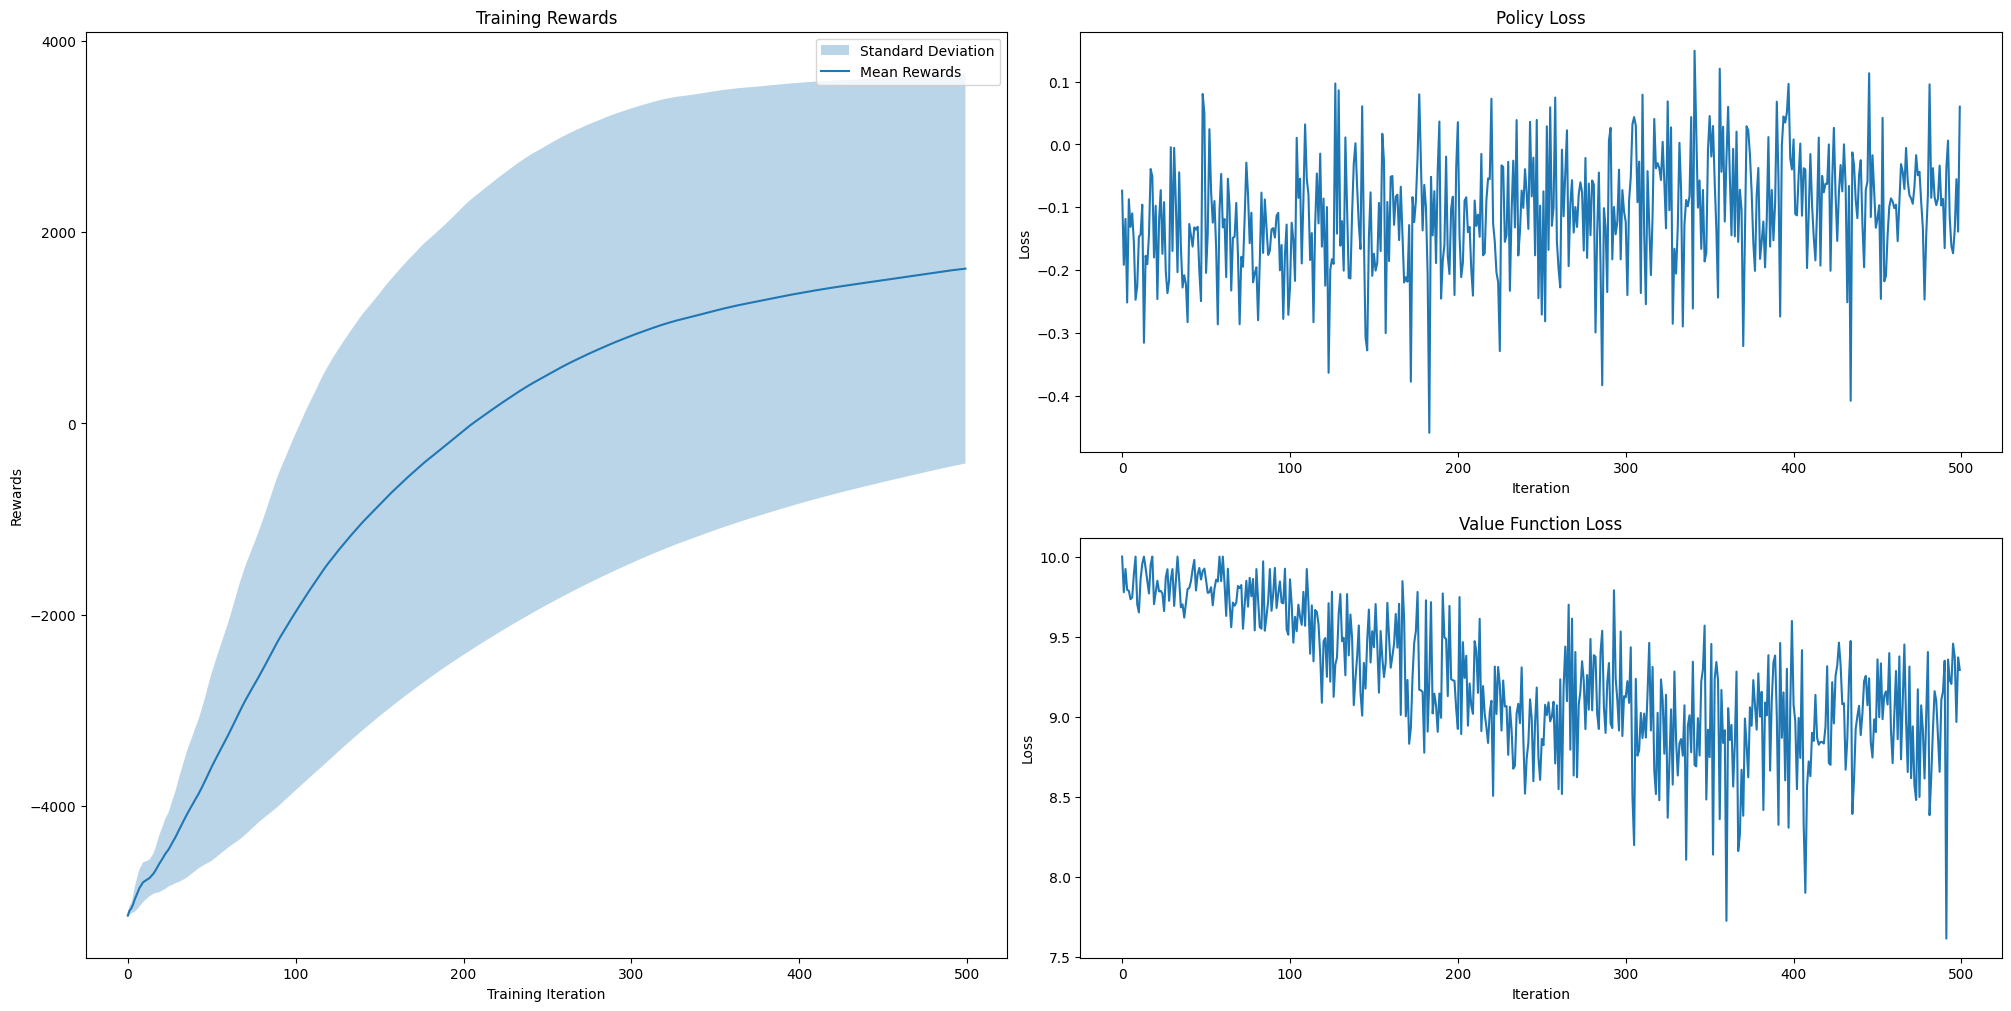

In [11]:
# Unpack values from each iteration
rewards = [i['env_runners']['episode_return_mean'] for i in results]
pol_loss = [i['learners']['default_policy']['policy_loss']for i in results]
vf_loss = [i['learners']['default_policy']['vf_loss'] for i in results]

p = 500
mean_rewards = np.array([np.mean(rewards[i-p:i+1])
                if i >= p else np.mean(rewards[:i+1])
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])


fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)),
                 mean_rewards - std_rewards,
                 mean_rewards + std_rewards,
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Training Iteration')
ax0.set_title('Training Rewards')
ax0.legend()
ax1 = fig.add_subplot(gs[0, 2:])
ax1.plot(pol_loss)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iteration')
ax1.set_title('Policy Loss')
ax2 = fig.add_subplot(gs[1, 2:])
ax2.plot(vf_loss)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Iteration')
ax2.set_title('Value Function Loss')


plt.show()

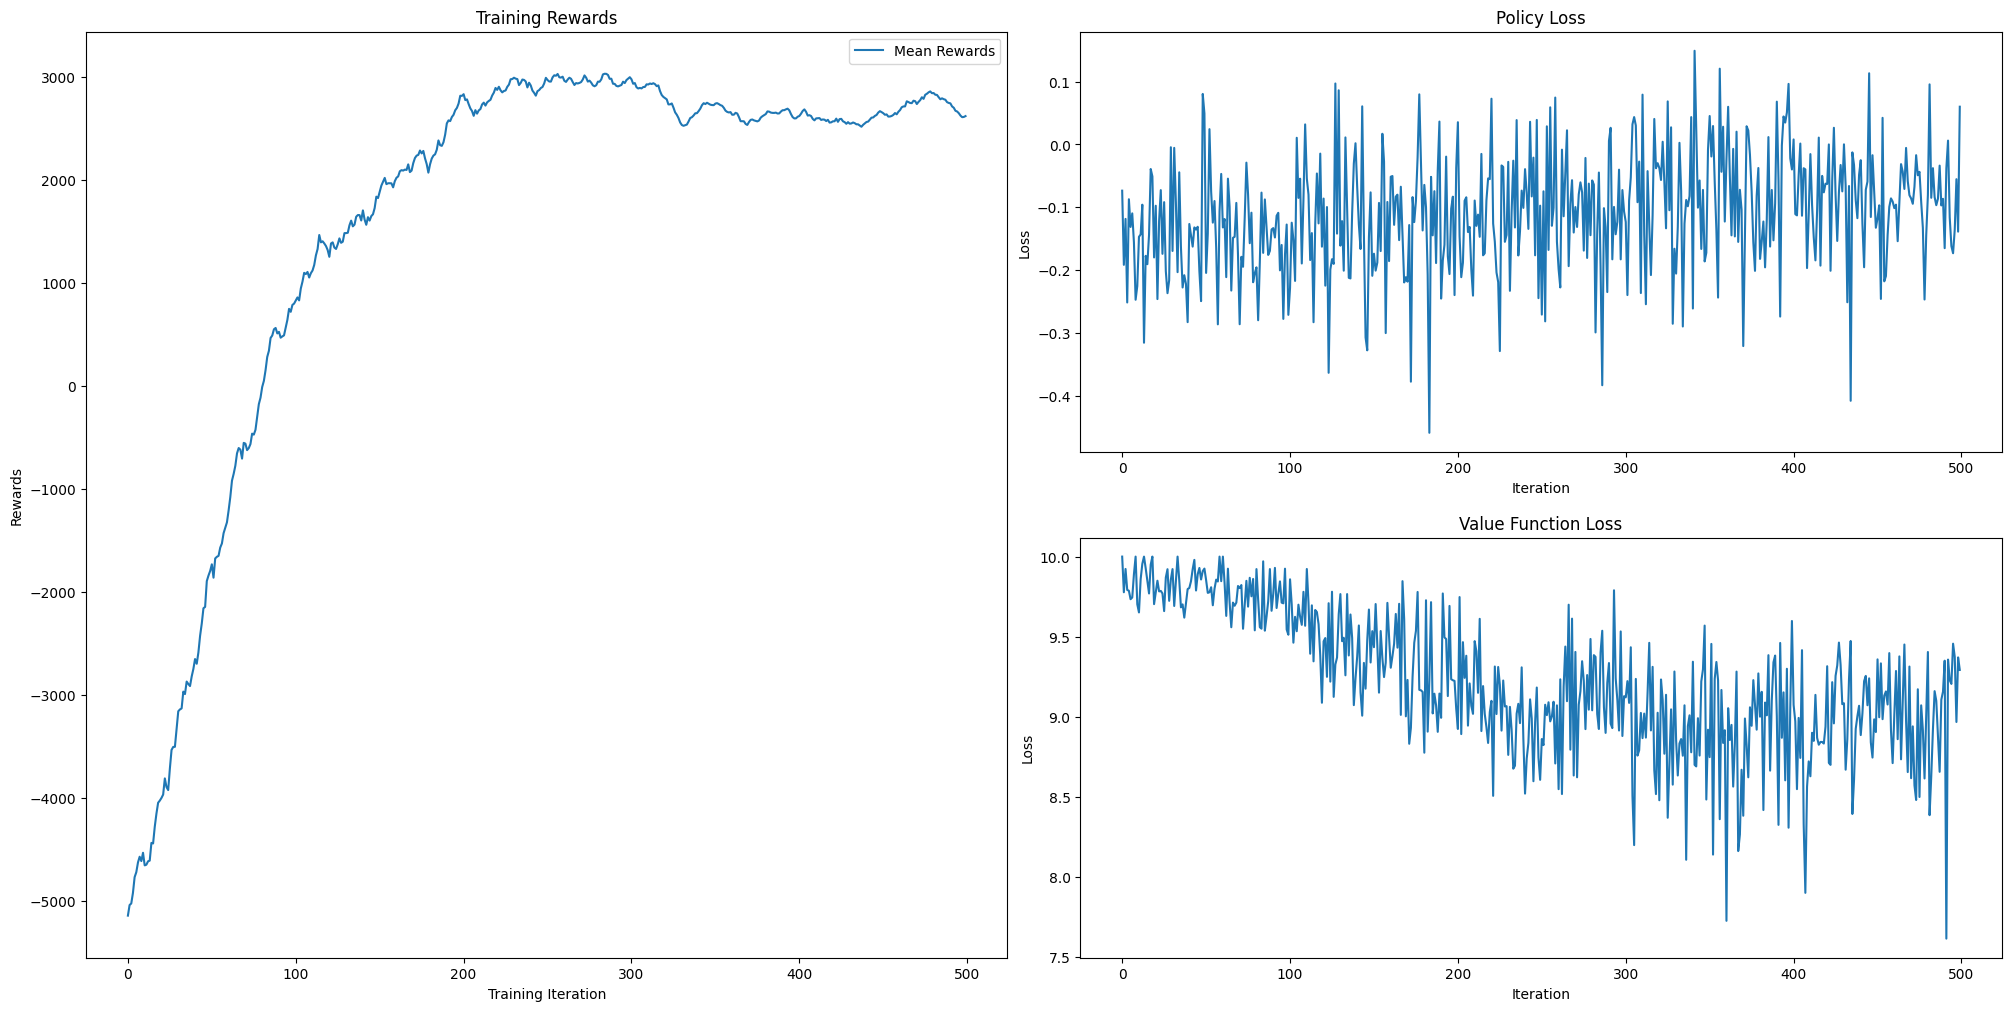

In [42]:
# Unpack values from each iteration
iter_rewards = [i['env_runners']['episode_return_mean'] for i in results]
pol_loss = [i['learners']['default_policy']['policy_loss']for i in results]
vf_loss = [i['learners']['default_policy']['vf_loss'] for i in results]


fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])

ax0.plot(iter_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Training Iteration')
ax0.set_title('Training Rewards')
ax0.legend()
ax1 = fig.add_subplot(gs[0, 2:])
ax1.plot(pol_loss)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iteration')
ax1.set_title('Policy Loss')
ax2 = fig.add_subplot(gs[1, 2:])
ax2.plot(vf_loss)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Iteration')
ax2.set_title('Value Function Loss')


plt.show()

# BASE STOCK POLICY

## DFO

In [12]:
from scipy.optimize import minimize

In [13]:
def base_stock_policy(policy, env):
  '''
  Implements a re-order up-to policy. This means that for
  each node in the network, if the inventory at that node
  falls below the level denoted by the policy, we will
  re-order inventory to bring it to the policy level.

  For example, policy at a node is 10, current inventory
  is 5: the action is to order 5 units.
  '''
  # print("Length of policy:", len(policy))  # Print for debugging
  # print("Length of env.init_inv:", len(env.init_inv))  # Print for debugging

  # Adjust policy length if necessary
  if len(policy) != len(env.init_inv):
    # Pad or truncate policy to match env.init_inv length
    # Replace '...' with appropriate logic based on your policy design
    if len(policy) < len(env.init_inv):
      # Pad policy (e.g., with zeros)
      policy = np.pad(policy, (0, len(env.init_inv) - len(policy)), 'constant', constant_values=0)
    else:
      # Truncate policy
      policy = policy[:len(env.init_inv)]

  # Get echelon inventory levels
  if env.period == 0:
    inv_ech = np.cumsum(env.I[env.period] + env.T[env.period])
  else:
    inv_ech = np.cumsum(env.I[env.period] + env.T[env.period] - env.B[env.period-1, :-1])

  # Get unconstrained actions
  unc_actions = policy - inv_ech
  unc_actions = np.where(unc_actions>0, unc_actions, 0)

  # Ensure that actions can be fulfilled by checking constraints
  inv_const = np.hstack([env.I[env.period, 1:], np.Inf])
  actions = np.minimum(env.c, np.minimum(unc_actions, inv_const))
  return actions

def dfo_func(policy, env, *args):
    '''
    Runs an episode based on current base-stock model
    settings. This allows us to use our environment for the
    DFO optimizer.
    '''
    env.reset() # Ensure env is fresh
    rewards = []
    done = False
    while not done:
        action = base_stock_policy(policy, env)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break

    rewards = np.array(rewards)
    prob = env.demand_dist.pmf(env.D, **env.dist_param)

    # Return negative of expected profit
    return -1 / env.num_periods * np.sum(prob * rewards)

def optimize_inventory_policy(env_name, fun,init_policy=None, env_config={}, method='Powell'):

  env = or_gym.make(env_name, env_config=env_config)

  if init_policy is None:
      init_policy = np.ones(env.num_stages-1)

  # Optimize policy
  out = minimize(fun=fun, x0=init_policy, args=env,
      method=method)
  policy = out.x.copy()

  # Policy must be positive integer
  policy = np.round(np.maximum(policy, 0), 0).astype(int)

  return policy, out

In [14]:


# Changed env_name to 'InvManagement-v0' to match the registered environment name
env_config = {'periods':240,
              'I0' : [100,100,150,200,200], #five arguements determiens 6 stages
              'p' : 10, # Final Product Price
              'r' : [1.5, 1.25, 1, 0.75, 0.5,0.25],
              'k': [0.15, 0.125, 0.1, 0.075, 0.05, 0.025],
              'h' : [0.25, 0.2, 0.15, 0.1, 0.05],

              'c' :[110, 100, 90, 80, 70],
              'L': [2,4,6,8,10],
              #'backlog':True,
              'dist': 1 # means positon, can try others
              }

policy, out = optimize_inventory_policy('InvManagement-v0',dfo_func,env_config=env_config)
print("Re-order levels: {}".format(policy))
print("DFO Info:\n{}".format(out))


dfo_env = or_gym.make('InvManagement-v0', env_config=env_config)
eps = 1000
dfo_rewards = []
for i in range(eps):
    dfo_env.reset()
    reward = 0
    while True:
        action = base_stock_policy(policy, dfo_env)
        s, r, done, _ = dfo_env.step(action)
        reward += r
        if done:
            dfo_rewards.append(reward)
            break

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment InvManagement-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` 

Re-order levels: [3 1 3 0 3]
DFO Info:
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.5679740697649325
       x: [ 3.382e+00  1.375e+00  3.071e+00 -2.186e+00  2.990e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 145


In [15]:
np.mean(dfo_rewards)

1841.3215190629628

## SHLP


In [16]:
import numpy as np
from scipy.optimize import minimize
import or_gym

def base_stock_policy(policy, env):
  '''
  Implements a re-order up-to policy. This means that for
  each node in the network, if the inventory at that node
  falls below the level denoted by the policy, we will
  re-order inventory to bring it to the policy level.

  For example, policy at a node is 10, current inventory
  is 5: the action is to order 5 units.
  '''
  # print("Length of policy:", len(policy))  # Print for debugging
  # print("Length of env.init_inv:", len(env.init_inv))  # Print for debugging

  # Adjust policy length if necessary
  if len(policy) != len(env.init_inv):
    # Pad or truncate policy to match env.init_inv length
    # Replace '...' with appropriate logic based on your policy design
    if len(policy) < len(env.init_inv):
      # Pad policy (e.g., with zeros)
      policy = np.pad(policy, (0, len(env.init_inv) - len(policy)), 'constant', constant_values=0)
    else:
      # Truncate policy
      policy = policy[:len(env.init_inv)]

  # Get echelon inventory levels
  if env.period == 0:
    inv_ech = np.cumsum(env.I[env.period] + env.T[env.period])
  else:
    inv_ech = np.cumsum(env.I[env.period] + env.T[env.period] - env.B[env.period-1, :-1])

  # Get unconstrained actions
  unc_actions = policy - inv_ech
  unc_actions = np.where(unc_actions>0, unc_actions, 0)

  # Ensure that actions can be fulfilled by checking constraints
  inv_const = np.hstack([env.I[env.period, 1:], np.Inf])
  actions = np.minimum(env.c, np.minimum(unc_actions, inv_const))
  return actions

def shlp_func(policy, env, num_simulations=100):
    """
    Evaluates a policy using SHLP.

    Args:
        policy (np.ndarray): The policy to evaluate.
        env (or_gym.envs.InventoryManagement): The inventory management environment.
        num_simulations (int): Number of simulations to run.

    Returns:
        float: The negative average reward over the simulations.
    """
    total_reward = 0
    for _ in range(num_simulations):
        env.reset()
        done = False
        while not done:
            action = base_stock_policy(policy, env)
            _, reward, done, _ = env.step(action)
            total_reward += reward

    return -total_reward / num_simulations  # Negative for minimization

def optimize_inventory_policy_shlp(env_name, env_config={}, num_simulations=100, method='Powell'):
    """
    Optimizes the inventory policy using SHLP and DFO.

    Args:
        env_name (str): The name of the inventory management environment.
        env_config (dict): Configuration for the environment.
        num_simulations (int): Number of simulations for SHLP evaluation.
        method (str): The DFO optimization method.

    Returns:
        tuple: The optimized policy and the optimization result.
    """
    env = or_gym.make(env_name, env_config=env_config)
    init_policy = np.ones(env.num_stages - 1)  # Initial policy

    # Optimize policy using SHLP as the objective function
    out = minimize(fun=shlp_func, x0=init_policy, args=(env, num_simulations), method=method) #add inital after first run
    policy = out.x.copy()

    # Policy must be positive integer
    policy = np.round(np.maximum(policy, 0), 0).astype(int)

    return policy, out



In [44]:
# Example usage
env_name = "InvManagement-v0"
env_config = {'periods':240,
              'I0' : [100,100,150,200,200], #five arguements determiens 6 stages
              'p' : 10, # Final Product Price
              'r' : [1.5, 1.25, 1, 0.75, 0.5,0.25],
              'k': [0.15, 0.125, 0.1, 0.075, 0.05, 0.025],
              'h' : [0.25, 0.2, 0.15, 0.1, 0.05],

              'c' :[110, 100, 90, 80, 70],
              'L': [2,4,6,8,10],
              #'backlog':True,
              'dist': 1 # means positon, can try others
              }

policy, out = optimize_inventory_policy_shlp(env_name, env_config)
print("Re-order levels:", policy)
print("SHLP???? Info:\n", out)

shlp_env = or_gym.make('InvManagement-v0', env_config=env_config)
eps = 1000
shlp_rewards = []
for i in range(eps):
    shlp_env.reset()
    reward = 0
    while True:
        action = base_stock_policy(policy, shlp_env)
        s, r, done, _ = shlp_env.step(action)
        reward += r
        if done:
            shlp_rewards.append(reward)
            break

Re-order levels: [ 347   26 2723  911  575]
SHLP???? Info:
  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -4017.2007729902953
       x: [ 3.469e+02  2.648e+01  2.723e+03  9.112e+02  5.749e+02]
     nit: 5
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 2.574e+00  1.836e-01 ...  6.778e+00  4.275e+00]]
    nfev: 360


In [36]:
np.mean(shlp_rewards)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3996.5134527913833

## ORACLE


In [23]:
import numpy as np
import or_gym

def oracle_policy(env):
  """
  Oracle policy with perfect foresight of demand.

  Args:
      env (or_gym.envs.InventoryManagement): The inventory management environment.

  Returns:
      np.ndarray: The optimal actions for the current period.
  """

  # Get future demand for the remaining periods
  future_demand = env.D[env.period:]

  # Calculate total demand for each stage
  # This line is modified to take into account the remaining periods only
  # Ensure total_demand has the same length as env.num_stages - 1
  total_demand = np.cumsum(future_demand[::-1])[::-1][:env.num_stages - 1]
  total_demand = np.pad(total_demand, (0, max(0, (env.num_stages - 1) - len(total_demand))), 'constant')

  # Calculate the optimal order quantities for each stage
  # to meet the total demand
  # This line is modified to use the current inventory level for all periods
  order_quantities = np.maximum(total_demand - env.I[env.period, :env.num_stages - 1], 0)

  # Apply constraints (capacity, available inventory, etc.)
  order_quantities = np.minimum(order_quantities, env.c)  # Capacity constraint
  # This line was also modified
  order_quantities = np.minimum(order_quantities, np.hstack([env.I[env.period, 1:env.num_stages - 1], np.Inf]))  # Available inventory constraint

  return order_quantities


def evaluate_oracle(env_name, env_config, num_episodes=1000):
  """
  Evaluates the oracle policy.

  Args:
      env_name (str): The name of the inventory management environment.
      env_config (dict): Configuration for the environment.
      num_episodes (int): Number of episodes to run.

  Returns:
      float: The average reward of the oracle policy.
  """
  env = or_gym.make(env_name, env_config=env_config)
  total_reward = 0

  for _ in range(num_episodes):
    env.reset()
    done = False
    while not done:
      action = oracle_policy(env)
      _, reward, done, _ = env.step(action)
      total_reward += reward

  return total_reward / num_episodes

In [45]:
# Example usage
env_name = "InvManagement-v0"
env_config = {'periods':240,
              'I0' : [100,100,150,200,200], #five arguements determiens 6 stages
              'p' : 10, # Final Product Price
              'r' : [1.5, 1.25, 1, 0.75, 0.5,0.25],
              'k': [0.15, 0.125, 0.1, 0.075, 0.05, 0.025],
              'h' : [0.25, 0.2, 0.15, 0.1, 0.05],

              'c' :[110, 100, 90, 80, 70],
              'L': [2,4,6,8,10],
              #'backlog':True,
              'dist': 1 # means positon, can try others
              }

oracle_reward = evaluate_oracle(env_name, env_config)
print("Oracle average reward:", oracle_reward*-1) #cause minimize is used

Oracle average reward: 4370.6488702047245


# DATA for report

In [21]:
#Table of mean est reward
  #DFO is 1841.321
import pandas as pd

results_dict = {}

results_dict['PPO'] = [results[-1]['env_runners']['episode_return_mean'],
                       0,
                       results[-1]['env_runners']['episode_return_min'],
                       results[-1]['env_runners']['episode_return_max'],
                       1/(results[-1]['env_runners']['episode_return_mean']/oracle_reward*-1)]

results_dict['DFO'] = [np.mean(dfo_rewards),
                        np.std(dfo_rewards),
                        np.min(dfo_rewards),
                        np.max(dfo_rewards),
                        1/(np.mean(dfo_rewards)/oracle_reward*-1)]
results_dict['SHLP'] = [np.mean(shlp_rewards),
                        np.std(shlp_rewards),
                        np.min(shlp_rewards),
                        np.max(shlp_rewards),
                        1/(np.mean(shlp_rewards)/oracle_reward*-1)]
results_dict['ORACLE'] = [oracle_reward*-1,
                          0,
                          oracle_reward*-1,
                          oracle_reward*-1,
                          1]

results_dict['PPO'] = [results[-1]['env_runners']['episode_return_mean'],
                       0,
                       results[-1]['env_runners']['episode_return_min'],
                       results[-1]['env_runners']['episode_return_max'],
                       1/(results[-1]['env_runners']['episode_return_mean']/oracle_reward*-1)]





results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['Mean', 'Std', 'Min', 'Max', 'Ratio']).reset_index()
results_df
  #SHLP 3996.5
  #ORACLE is 4370

  #TRAIN RF MORE



#std of reseults
  #for length
   #CReate list
  #lines for each

  #Violin?




#model for Ray


,index,Mean,Std,Min,Max,Ratio
0,PPO,2619.212074,0.000000,2171.627701,2957.164234,1.668688
1,DFO,1841.321519,78.781434,1586.244497,2042.833487,2.373648
2,SHLP,3996.513453,160.648783,3498.187518,4451.713375,1.093615
3,ORACLE,4370.648870,0.000000,4370.648870,4370.648870,1.000000


In [ ]:
#export data?

# Export as PDF

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1
  libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53
  libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick
  ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-free

In [47]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab Notebooks/OR_GYM_MIE1666.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/OR_GYM_MIE1666.ipynb to pdf
[NbConvertApp] Support files will be in OR_GYM_MIE1666_files/
[NbConvertApp] Making directory ./OR_GYM_MIE1666_files
[NbConvertApp] Writing 157855 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 582749 bytes to /content/drive/MyDrive/Colab Notebooks/OR_GYM_MIE1666.pdf
